## Refs

Follow notebook `cat_dog_transfer_learning.ipynb`

In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [1]:
# !ls drive/MyDrive/ML_colab/

dataset  datasetbeach_mountain	pretrained  save


In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
# local_weights_file = '../pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# local_weights_file = 'drive/MyDrive/ML_colab/pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [6]:
im_dim = (200, 200)
pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = "imagenet")

# pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 10, 10, 768)


In [9]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=1e-5), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# !mv drive/MyDrive/ML_colab/datasetbeach_mountain/beach_mountain drive/MyDrive/ML_colab/dataset/

In [7]:
# only on colab
# import zipfile

# dataset_dir = 'drive/MyDrive/ML_colab/dataset'
# zip_file = dataset_dir + '/beach_mountain.zip'
# zip_ref = zipfile.ZipFile(zip_file, 'r')
# zip_ref.extractall(dataset_dir+'/b_m')
# zip_ref.close()

In [10]:
# !ls drive/MyDrive/ML_colab/dataset/b_m/beach_mountain/

train  validation


In [ ]:
# %%time
# import zipfile

# dataset_dir = 'drive/MyDrive/ML_colab/dataset'
# zip_file = dataset_dir + '/beach_mountain.zip'
# zip_ref = zipfile.ZipFile(zip_file, 'r')
# zip_ref.extractall("/tmp")
# zip_ref.close()

In [10]:
# local data

base_dir = "../dataset/beach_mountain"
# base_dir = "drive/MyDrive/ML_colab/dataset/beach_mountain"
# base_dir = "drive/MyDrive/ML_colab/dataset/b_m/beach_mountain/"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

test_dir = os.path.join(base_dir, 'test_2')

train_beach_dir = os.path.join(train_dir, 'beach')
train_moutain_dir = os.path.join(train_dir, 'mountain')

validation_beach_dir = os.path.join(validation_dir, 'beach')
validation_mountain_dir = os.path.join(validation_dir, 'mountain')

test_beach_dir = os.path.join(test_dir, 'beach')
test_moutain_dir = os.path.join(test_dir, 'mountain')

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

batch_size = 50
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = im_dim)

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size  = batch_size,
                                                         class_mode  = 'binary', 
                                                         target_size = im_dim)

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size  = batch_size,
                                                         class_mode  = 'binary', 
                                                         target_size = im_dim)

Found 9000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.96) :
            print("\nReached 96.0% accuracy so cancelling training!")
            self.model.stop_training = True

my_callback = myCallback()

In [14]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = validation_generator.n//validation_generator.batch_size,
            epochs = 100,
            validation_steps = validation_generator.n//validation_generator.batch_size,
            verbose = 2,
            callbacks=[my_callback])

Epoch 1/100
20/20 - 14s - loss: 0.5051 - accuracy: 0.7520 - val_loss: 0.3327 - val_accuracy: 0.8890
Epoch 2/100
20/20 - 9s - loss: 0.3821 - accuracy: 0.8370 - val_loss: 0.2636 - val_accuracy: 0.9050
Epoch 3/100
20/20 - 9s - loss: 0.3201 - accuracy: 0.8760 - val_loss: 0.2246 - val_accuracy: 0.9170
Epoch 4/100
20/20 - 9s - loss: 0.2957 - accuracy: 0.8790 - val_loss: 0.2116 - val_accuracy: 0.9170
Epoch 5/100
20/20 - 9s - loss: 0.2495 - accuracy: 0.9030 - val_loss: 0.1904 - val_accuracy: 0.9240
Epoch 6/100
20/20 - 9s - loss: 0.2482 - accuracy: 0.8990 - val_loss: 0.1827 - val_accuracy: 0.9320
Epoch 7/100
20/20 - 9s - loss: 0.2558 - accuracy: 0.8860 - val_loss: 0.1801 - val_accuracy: 0.9310
Epoch 8/100
20/20 - 9s - loss: 0.2470 - accuracy: 0.8990 - val_loss: 0.1939 - val_accuracy: 0.9260
Epoch 9/100
20/20 - 9s - loss: 0.2605 - accuracy: 0.8910 - val_loss: 0.1729 - val_accuracy: 0.9340
Epoch 10/100
20/20 - 9s - loss: 0.2366 - accuracy: 0.9060 - val_loss: 0.1697 - val_accuracy: 0.9380
Epoch 11

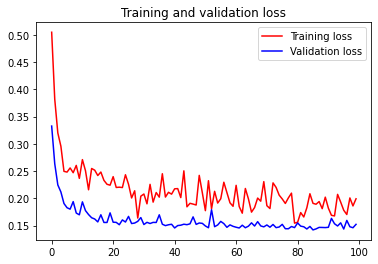

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# loss
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

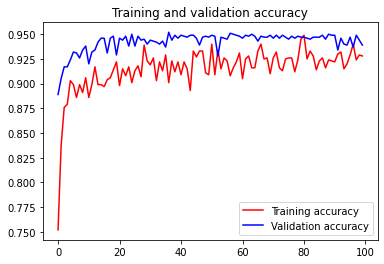

<Figure size 432x288 with 0 Axes>

In [16]:
# accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [44]:
test_generator.reset()
model.evaluate(test_generator)

4/4 [==============================] - 1s 113ms/step - loss: 0.1857 - accuracy: 0.9350


[0.1857421100139618, 0.9350000023841858]

In [56]:
test_dir = os.path.join(base_dir, 'internet')

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

test_beach_dir = os.path.join(test_dir, 'beach')
test_moutain_dir = os.path.join(test_dir, 'mountain')

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size  = batch_size,
                                                         class_mode  = 'binary', 
                                                         target_size = im_dim)

test_generator.reset()
model.evaluate(test_generator)

Found 10 images belonging to 2 classes.
1/1 [==============================] - 1s 884ms/step - loss: 0.4551 - accuracy: 0.8000


[0.4551108479499817, 0.800000011920929]

In [20]:
# check the labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'beach', 1: 'mountain'}

In [21]:
import numpy as np

In [75]:
test_generator.reset()
pred = model.predict(test_generator, verbose=1)
predicted_class_indices=(pred>0.5).astype("int32")
predictions = [labels[k[0]] for k in predicted_class_indices]
predictions

1/1 [==============================] - 0s 160ms/step


['mountain',
 'beach',
 'mountain',
 'mountain',
 'mountain',
 'beach',
 'mountain',
 'beach',
 'beach',
 'beach']

In [68]:
im_dim

(200, 200)

In [36]:
from tensorflow.keras.preprocessing import image

In [81]:
# predict for an uploaded image
file_path = '../dataset/beach_mountain/internet_2/' # current dir
# file_path = '../dataset/beach_mountain/test/beach/' # current dir
# file_path = '../dataset/beach_mountain/test/mountain/' # current dir
test_files = os.listdir(file_path)

for file in test_files:
    # predicting images
    path=file_path + file
    img=image.load_img(path, target_size=im_dim)
    x=image.img_to_array(img)
    x=x/255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    classes = model.predict(images)
    classes = (classes > 0.5).astype("int32")[0][0]
    print(classes)

    if classes>0:
        print(file + " is a mountain\n")
    else:
        print(file + " is a beach\n")

1
mountain2.jpg is a mountain

0
mountain1.jpg is a beach

1
mountain5.jpeg is a mountain

1
beach1.jpg is a mountain

1
mountain3.jpg is a mountain

0
beach5.jpeg is a beach

0
beach3.jpg is a beach

1
mountain4.png is a mountain

0
beach4.jpeg is a beach

0
beach2.jpeg is a beach



In [85]:
# from an image
test_file = "../dataset/beach_mountain/internet_2/mountain1.jpg"
img = image.load_img(test_file, target_size=im_dim)
x = image.img_to_array(img)
x = x/255
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images)
classes = (classes > 0.5).astype("int32")[0]

if classes>0:
    print(test_file.split("/")[-1] + " is a mountain")
else:
    print(test_file.split("/")[-1] + " is a beach")

mountain1.jpg is a beach


In [19]:
saved_model_path = "../saved_model"

model.save(saved_model_path + '/SavedModel_100e_945_pre_imagenet_inceptionv3_200')
model.save(saved_model_path + '/model_100e_945_pre_imagenet_inceptionv3_200.h5')

# model.save("drive/MyDrive/ML_colab/save/beach_mountain/100epochs/SavedModel_100e_94")

INFO:tensorflow:Assets written to: ../saved_model/SavedModel_100e_945_pre_imagenet_inceptionv3_200/assets


In [21]:
# model.save("drive/MyDrive/ML_colab/save/beach_mountain/100epochs/model_100e_94.h5")

In [ ]:
# keep colab alive
# while True:pass